# Complex Noise Signal Prediction with LSTM

This notebook trains an LSTM on a complex chaotic signal generated by a logistic map with quasi-periodic forcing.

## Signal Generation

The signal is generated using:

$$x[t+1] = r \cdot x[t] \cdot (1 - x[t]) + \epsilon \cdot \sin(\omega_1 \cdot t) + \delta \cdot \sin(\omega_2 \cdot t)$$

Where:
- $r = 3.87$ (chaotic regime of logistic map)
- $\epsilon = 0.05$, $\delta = 0.03$ (forcing amplitudes)
- $\omega_1 = \sqrt{2}$, $\omega_2 = \pi/e$ (incommensurate frequencies)

This creates a challenging prediction task combining:
- Deterministic chaos (sensitive dependence on initial conditions)
- Quasi-periodic forcing (irrational frequency ratio prevents exact periodicity)

In [1]:
import sys
from pathlib import Path
from typing import Tuple, Optional, List
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
sys.path.insert(0, str(Path.cwd().parent / "src"))

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

## 1. Signal Generation

Generate the chaotic logistic map signal with quasi-periodic forcing.

In [2]:
def generate_signal(T: int = 1000, x0: float = 0.2) -> np.ndarray:
    """
    Generate chaotic logistic map signal with quasi-periodic forcing.
    
    Args:
        T: Number of timesteps to generate
        x0: Initial condition
        
    Returns:
        Signal array of shape (T,) with values in [0, 1]
    """
    r = 3.87
    eps = 0.05
    delta = 0.03
    w1 = np.sqrt(2.0)
    w2 = np.pi / np.e

    x = np.zeros(T)
    x[0] = x0

    for t in range(T - 1):
        forcing = eps * np.sin(w1 * t) + delta * np.sin(w2 * t)
        x_next = r * x[t] * (1 - x[t]) + forcing

        # clip to [0, 1] so the system does not blow up
        x[t + 1] = np.clip(x_next, 0.0, 1.0)

    return x


# Generate signal
SIGNAL_LENGTH = 2000
signal = generate_signal(T=SIGNAL_LENGTH, x0=0.2)

print(f"Signal shape: {signal.shape}")
print(f"Signal range: [{signal.min():.4f}, {signal.max():.4f}]")
print(f"Signal mean: {signal.mean():.4f}")
print(f"Signal std: {signal.std():.4f}")

Signal shape: (2000,)
Signal range: [0.0000, 1.0000]
Signal mean: 0.5551
Signal std: 0.3219


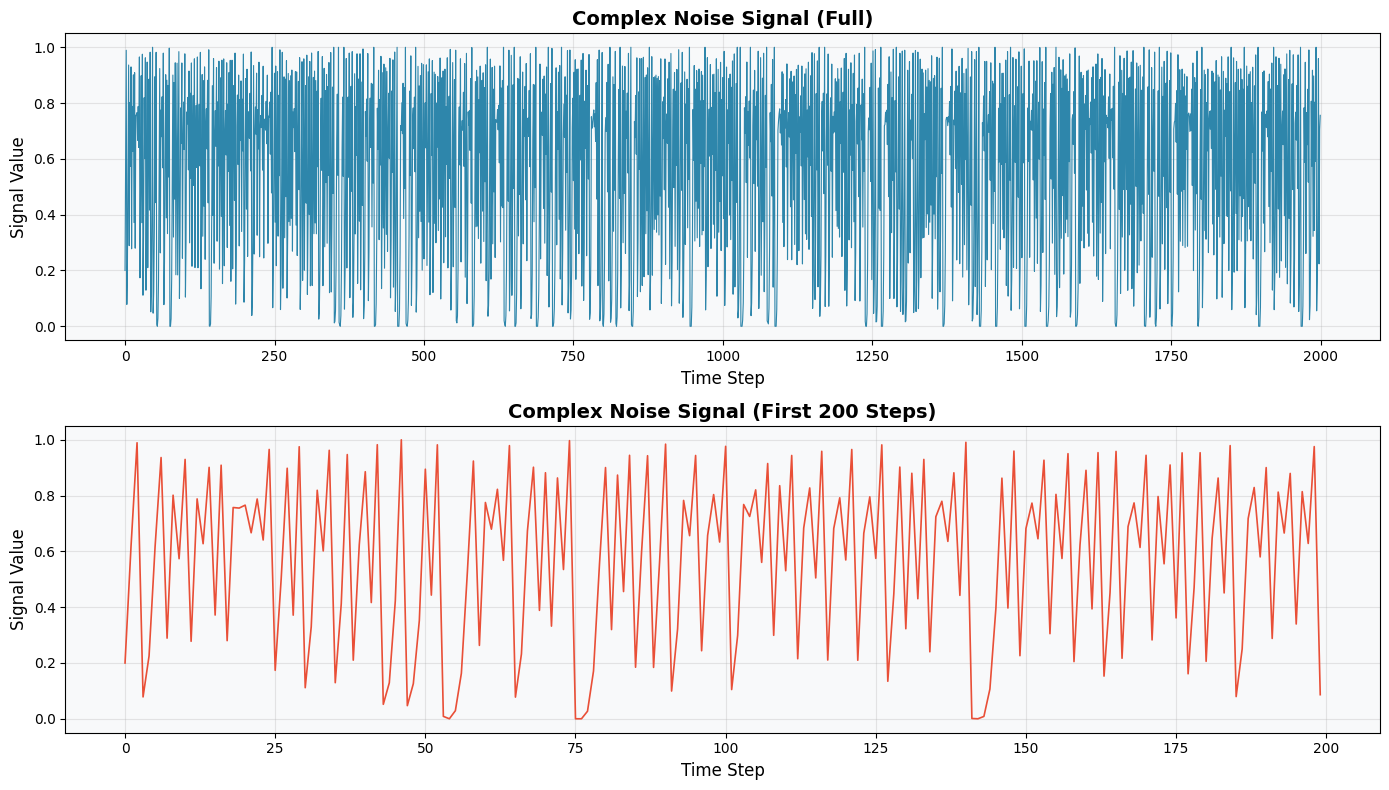

In [3]:
# Visualize the generated signal
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Full signal
ax1 = axes[0]
ax1.plot(signal, color='#2E86AB', linewidth=0.8)
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Signal Value', fontsize=12)
ax1.set_title('Complex Noise Signal (Full)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#F8F9FA')

# Zoomed view
ax2 = axes[1]
ax2.plot(signal[:200], color='#E94F37', linewidth=1.2)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Complex Noise Signal (First 200 Steps)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

## 2. Data Preparation

Create overlapping sequences for next-step prediction.

In [4]:
def create_sequences(
    signal: np.ndarray,
    seq_len: int = 50,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create overlapping sequences for next-step prediction.
    
    Args:
        signal: 1D signal array
        seq_len: Length of each input sequence
        
    Returns:
        X: Input sequences of shape (num_samples, seq_len, 1)
        Y: Target values of shape (num_samples, 1)
    """
    X, Y = [], []
    for i in range(len(signal) - seq_len):
        X.append(signal[i:i + seq_len])
        Y.append(signal[i + seq_len])
    
    X = np.array(X, dtype=np.float32).reshape(-1, seq_len, 1)
    Y = np.array(Y, dtype=np.float32).reshape(-1, 1)
    
    return X, Y


# Create sequences
SEQ_LEN = 50
X, Y = create_sequences(signal, seq_len=SEQ_LEN)

# Train/test split (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (1560, 50, 1)
Y_train shape: (1560, 1)
X_test shape: (390, 50, 1)
Y_test shape: (390, 1)


## 3. Model Setup

Initialize the 1997 LSTM cell with forget gate (modern extension).

In [5]:
import torch
import torch.nn as nn
from aquarius_lstm.cell_torch import LSTMCell1997WithForgetGate

# Set seeds
torch.manual_seed(SEED)

# Hyperparameters
HIDDEN_SIZE = 32
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 100

# Convert to tensors
X_train_t = torch.tensor(X_train)
Y_train_t = torch.tensor(Y_train)
X_test_t = torch.tensor(X_test)
Y_test_t = torch.tensor(Y_test)

# Build model
cell = LSTMCell1997WithForgetGate(
    input_size=1,
    hidden_size=HIDDEN_SIZE,
    input_gate_bias=0.0,
    forget_gate_bias=1.0,
    seed=SEED,
)
linear = nn.Linear(HIDDEN_SIZE, 1)

params = list(cell.parameters()) + list(linear.parameters())
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE)
criterion = nn.MSELoss()

print(f"Model initialized with {HIDDEN_SIZE} hidden units")
print(f"Total parameters: {sum(p.numel() for p in params)}")

Model initialized with 32 hidden units
Total parameters: 4385


## 4. Training Loop

In [6]:
# Training loop
losses = []
num_batches = len(X_train) // BATCH_SIZE
LOG_EVERY = 10

print(f"Training for {NUM_EPOCHS} epochs...")
print(f"Batches per epoch: {num_batches}")
print("="*60)

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    
    # Shuffle training data
    perm = np.random.permutation(len(X_train))
    X_train_shuffled = X_train_t[perm]
    Y_train_shuffled = Y_train_t[perm]
    
    for batch_idx in range(num_batches):
        start = batch_idx * BATCH_SIZE
        end = start + BATCH_SIZE
        
        X_batch = X_train_shuffled[start:end]  # (batch, seq_len, 1)
        Y_batch = Y_train_shuffled[start:end]  # (batch, 1)
        
        optimizer.zero_grad()
        
        # Initialize hidden state
        h, s_c = cell.init_state(batch_size=BATCH_SIZE)
        
        # Forward through sequence (seq_len, batch, input_size)
        X_seq = X_batch.permute(1, 0, 2)  # (seq_len, batch, 1)
        for t in range(SEQ_LEN):
            h, s_c = cell(X_seq[t], h, s_c)
        
        # Predict
        pred = linear(h)
        loss = criterion(pred, Y_batch)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % LOG_EVERY == 0:
        print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS}: Loss = {avg_loss:.6f}")

print("="*60)
print(f"Training complete! Final loss: {losses[-1]:.6f}")

Training for 100 epochs...
Batches per epoch: 48
Epoch  10/100: Loss = 0.106376
Epoch  20/100: Loss = 0.106946
Epoch  30/100: Loss = 0.104446
Epoch  40/100: Loss = 0.101722
Epoch  50/100: Loss = 0.092678
Epoch  60/100: Loss = 0.065574
Epoch  70/100: Loss = 0.036555
Epoch  80/100: Loss = 0.018439
Epoch  90/100: Loss = 0.007998
Epoch 100/100: Loss = 0.003695
Training complete! Final loss: 0.003695


## 5. Loss Curve

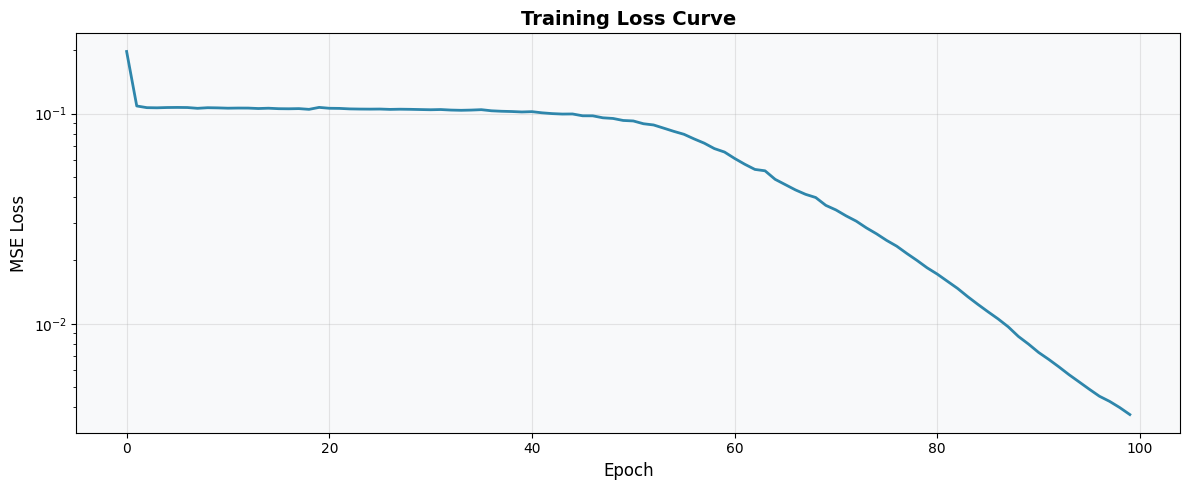

In [7]:
# Plot loss curve
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(losses, color='#2E86AB', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('MSE Loss', fontsize=12)
ax.set_title('Training Loss Curve', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

## 6. Evaluation

In [8]:
# Evaluate on test set
print("Evaluating on test set...")
predictions = []

with torch.no_grad():
    # Process test set in batches
    test_batches = (len(X_test) + BATCH_SIZE - 1) // BATCH_SIZE
    
    for batch_idx in range(test_batches):
        start = batch_idx * BATCH_SIZE
        end = min(start + BATCH_SIZE, len(X_test))
        actual_batch_size = end - start
        
        X_batch = X_test_t[start:end]
        
        h, s_c = cell.init_state(batch_size=actual_batch_size)
        
        X_seq = X_batch.permute(1, 0, 2)
        for t in range(SEQ_LEN):
            h, s_c = cell(X_seq[t], h, s_c)
        
        pred = linear(h)
        predictions.append(pred.numpy())

y_pred = np.concatenate(predictions, axis=0)
y_true = Y_test

# Calculate metrics
mse = np.mean((y_pred - y_true) ** 2)
mae = np.mean(np.abs(y_pred - y_true))
rmse = np.sqrt(mse)

print(f"\nTest Results:")
print(f"  MSE:  {mse:.6f}")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")

Evaluating on test set...

Test Results:
  MSE:  0.002925
  RMSE: 0.054080
  MAE:  0.043204


## 7. Signal Comparison

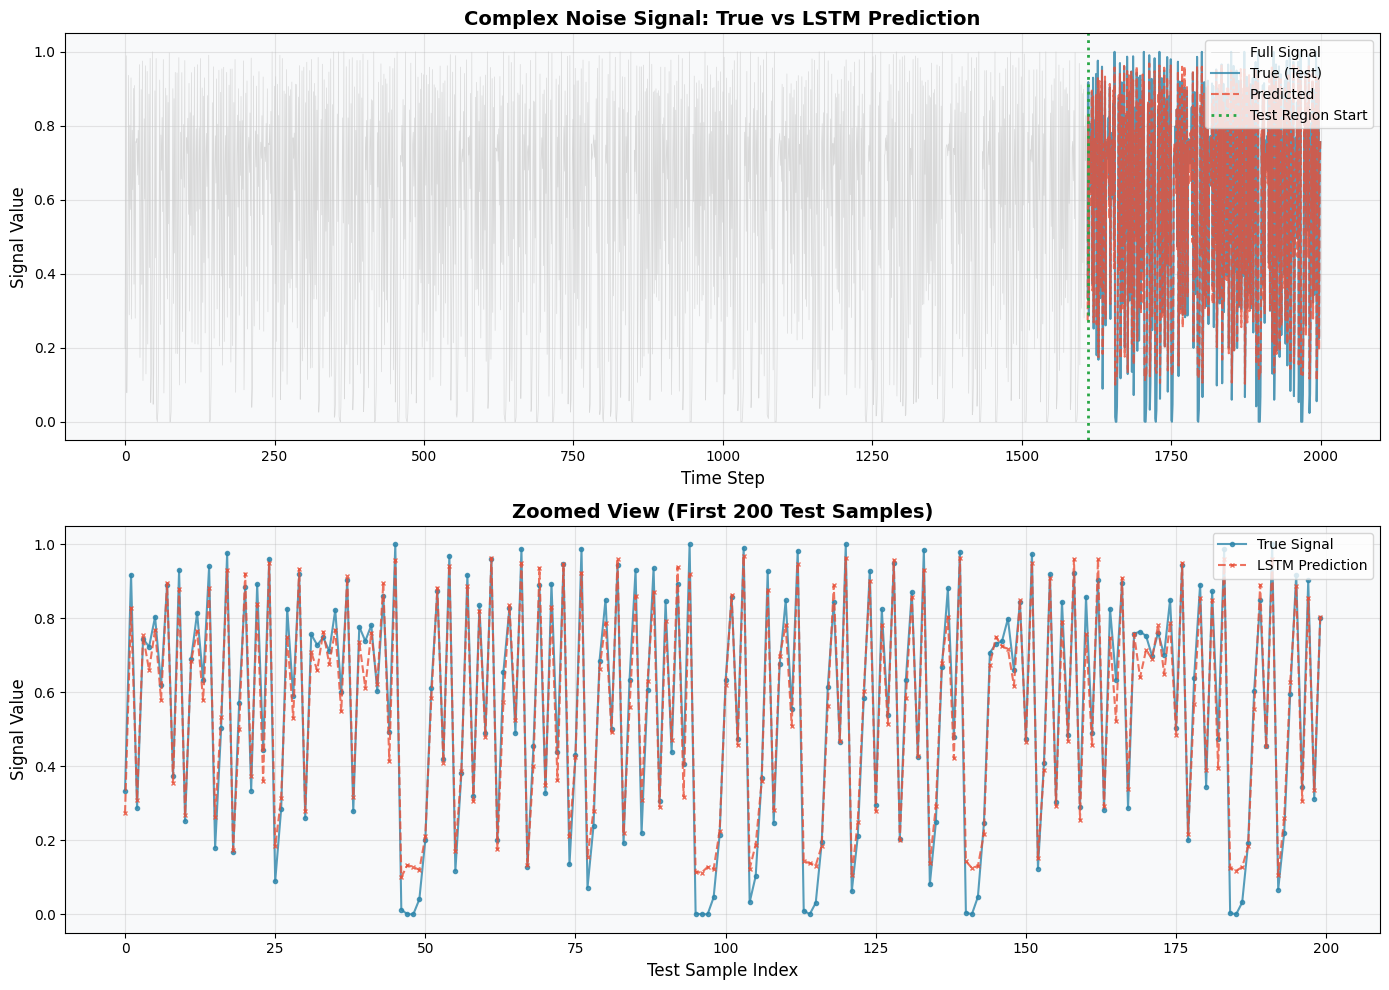

In [9]:
# Plot signal comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Full signal with test region highlighted
ax1 = axes[0]
time_full = np.arange(len(signal))
ax1.plot(time_full, signal, color='#CCCCCC', linewidth=0.5, label='Full Signal', alpha=0.7)

# Highlight test region
test_start = split_idx + SEQ_LEN
time_test = np.arange(test_start, test_start + len(y_true))

ax1.plot(time_test, y_true.flatten(), color='#2E86AB', linewidth=1.5, 
         label='True (Test)', alpha=0.8)
ax1.plot(time_test, y_pred.flatten(), color='#E94F37', linewidth=1.5, 
         label='Predicted', linestyle='--', alpha=0.8)

ax1.axvline(x=test_start, color='#28A745', linestyle=':', linewidth=2, 
            label='Test Region Start')

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Signal Value', fontsize=12)
ax1.set_title('Complex Noise Signal: True vs LSTM Prediction', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#F8F9FA')

# Zoomed view of test region
ax2 = axes[1]
zoom_samples = 200

ax2.plot(y_true[:zoom_samples].flatten(), color='#2E86AB', linewidth=1.5, 
         label='True Signal', marker='o', markersize=3, alpha=0.8)
ax2.plot(y_pred[:zoom_samples].flatten(), color='#E94F37', linewidth=1.5, 
         label='LSTM Prediction', linestyle='--', marker='x', markersize=3, alpha=0.8)

ax2.set_xlabel('Test Sample Index', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title(f'Zoomed View (First {zoom_samples} Test Samples)', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

## 8. Error Distribution

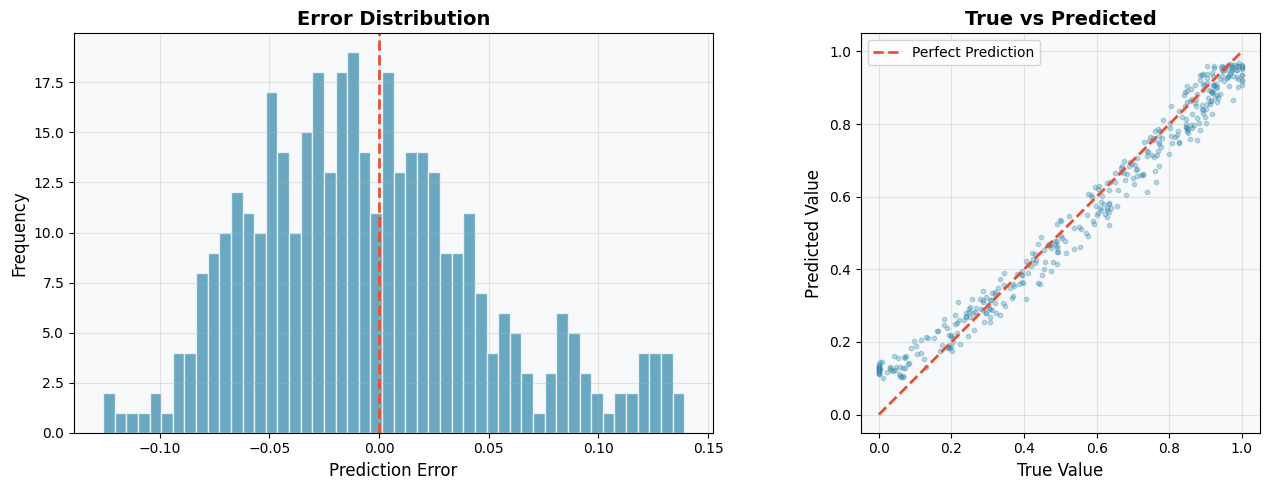

In [10]:
# Plot error distribution
errors = y_pred.flatten() - y_true.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
ax1 = axes[0]
ax1.hist(errors, bins=50, color='#2E86AB', edgecolor='white', alpha=0.7)
ax1.axvline(x=0, color='#E94F37', linestyle='--', linewidth=2)
ax1.set_xlabel('Prediction Error', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Error Distribution', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#F8F9FA')

# Scatter plot: True vs Predicted
ax2 = axes[1]
ax2.scatter(y_true.flatten(), y_pred.flatten(), color='#2E86AB', alpha=0.3, s=10)
ax2.plot([0, 1], [0, 1], color='#E94F37', linestyle='--', linewidth=2, label='Perfect Prediction')
ax2.set_xlabel('True Value', fontsize=12)
ax2.set_ylabel('Predicted Value', fontsize=12)
ax2.set_title('True vs Predicted', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#F8F9FA')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **Signal Generation**: Created a chaotic logistic map with quasi-periodic forcing
2. **Data Preparation**: Converted the signal into sequences for next-step prediction
3. **LSTM Training**: Used the 1997 LSTM architecture with forget gate extension
4. **Visualization**: Plotted loss curves and true vs predicted signals

The LSTM learns to approximate the complex dynamics of the chaotic system, though perfect prediction is impossible due to the sensitivity to initial conditions inherent in chaos.